In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style('darkgrid')
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.model_selection import train_test_split
import statistics 


# Read in the data
Here we shall read the data into 3 separate dataframes based on the review type.
The data has been previously cleaned in terms of null values and ratings.We need to have an equal number of review types such that our data is not skewed so we shall use the pandas.sample() method to achieve this.
We will then read each review appending them to a list such that we have each review type as a list of strings.

In [2]:
# Read in data
df_neutral = pd.read_csv("Neutral_Reviews.csv")
df_negative = pd.read_csv("Negative_Reviews.csv")
df_positive = pd.read_csv("Positive_Reviews.csv")

print(f"There are: \n{len(df_neutral)} neutral reviews \n{len(df_negative)} negative reviews \n{len(df_positive)} positive reviews")

There are: 
40852 neutral reviews 
26937 negative reviews 
1003562 positive reviews


In [3]:
# Sample data - Aswe have a minimum number of negative reviews I shall sample 26,000 from each dataframe.

df_neutral = df_neutral.sample(n=26000)
df_negative = df_negative.sample(n=26000)
df_positive = df_positive.sample(n=26000)


In [4]:
# Put all reviews in list form

neutral_reviews=[]
negative_reviews=[]
positive_reviews=[]

for i in df_neutral.review:
    neutral_reviews.append(i)
    
for i in df_negative.review:
    negative_reviews.append(i)

for i in df_positive.review:
    positive_reviews.append(i)
    
positive_reviews[0:3]

['I made this tonight and it was so good!!!  I did substitute olive oil for the butter, but other than that followed the recipe and we all loved it!  YUMMY!',
 "5 stars for sure!! This shrimp was awesome and I could have just kept eating and eating them. I did not measure the pepper, but I don't think I used the full amount, but I do believe the amount would work, even though it's pretty high :) Will be making again!",
 'Very good chicken!  The skins were SOOOO good!  Chicken came out tender and cooked well after about 35 minutes.']

# Review Length
Find the min and max length of each review (in characters NOT words)

In [5]:
all_reviews=[negative_reviews,neutral_reviews,positive_reviews]

neu=[]
neg=[]
pos=[]

for i in all_reviews:
    for review in i:
        if i == negative_reviews:
            neg.append(len(review))
        elif i == neutral_reviews:
            neu.append(len(review))
        else:
            pos.append(len(review))
print(max(neu),min(neu),max(neg),min(neg),max(pos),min(pos))

4652 3 4146 1 4592 1


# Clean the Data
Here I shall remove punctuation and symbols as well as making each word lowercase. this allows us to analyze the data later on.
Ideally we will also lematize and stem the words.

In [7]:
# Import necessary libraries and create our regex functions to remove certain characters and punctuation.

import re
import nltk
from nltk.corpus import stopwords
import string

# The regex code for the symbols and punctuation to be removed. We will simply remove the punctuation but
# will replace the set of symbols with a space so we don'tjoin two separate words together!

replace_with_space = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)|(\n*\n)|(\r*\n)|(#&)")
remove = re.compile("[.;:!\'?,\"()\[\]]")

def remove_symbols(review_list):
    reviews = [replace_with_space.sub(" ", i.lower()) for i in review_list]
    
    return reviews

def remove_punctuation(review_list):
    reviews = [remove.sub("", i.lower() ) for i in review_list]
    
    return reviews

In [8]:
# Run our cleaning functions
# Train-test split, 80/20

neutral_reviews = remove_symbols(neutral_reviews)
neutral_reviews = remove_punctuation(neutral_reviews)
neutral_reviews_train = neutral_reviews[:20800]
neutral_reviews_test = neutral_reviews[20800:]

negative_reviews = remove_symbols(negative_reviews)
negative_reviews = remove_punctuation(negative_reviews)
negative_reviews_train = negative_reviews[:20800]
negative_reviews_test = negative_reviews[20800:]
                                      
positive_reviews = remove_symbols(positive_reviews)
positive_reviews = remove_punctuation(positive_reviews)
positive_reviews_train = positive_reviews[:20800]
positive_reviews_test = positive_reviews[20800:]


In [9]:
# Sanity check!
positive_reviews_train[1]
# len(positive_reviews_train)

'5 stars for sure this shrimp was awesome and i could have just kept eating and eating them i did not measure the pepper but i dont think i used the full amount but i do believe the amount would work even though its pretty high  will be making again'

In [10]:
list_of_reviews_train=[positive_reviews_train,neutral_reviews_train,negative_reviews_train]
all_reviews_train=[]

for reviews in list_of_reviews_train:
    for review in reviews:
        all_reviews_train.append(review)

list_of_reviews_test=[positive_reviews_test,neutral_reviews_test,negative_reviews_test]
all_reviews_test=[]

for reviews in list_of_reviews_test:
    for review in reviews:
        all_reviews_test.append(review)

print(len(all_reviews_test),len(all_reviews_train))

15600 62400


In [57]:
from sklearn.feature_extraction.text import CountVectorizer

# Create the corpus of words contained within all of our documents - Bag of words
cv = CountVectorizer(binary=True)
cv.fit(all_reviews_train)

# Transform reviews into sparse matrix based on words contained in corpus
X_train = cv.transform(all_reviews_train)
X_test = cv.transform(all_reviews_test)

In [58]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Store the target in a list to fit our model to
target_train=[]

# Append list with target values for all reviews in training data
for i in range(len(all_reviews_train)):
    
    if i<len(positive_reviews_train):
        target_train.append(2)        
    elif len(positive_reviews_train) <= i < len(neutral_reviews_train):
        target_train.append(1)        
    else:
        target_train.append(0)

# Split the training data further into training and validation groups to test our models against
X_train, X_val, y_train, y_val = train_test_split(X_train, target_train, train_size = 0.8)


In [59]:
len(all_reviews_train),len(target_train)

(62400, 62400)

In [25]:

# for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
#     lr = LogisticRegression(C=c)
#     lr.fit(X_train, y_train)
#     print ("Accuracy for C=%s: %s" 
#            % (c, accuracy_score(y_test, lr.predict(X_test))))

lr = LogisticRegression(C=0.05)
lr.fit(X_train, y_train)
print ("Final Accuracy: %s" 
       % accuracy_score(y_val, lr.predict(X_val)))


/Users/flatironschool/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/flatironschool/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Final Accuracy: 0.747275641025641


In [28]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix


clf = DecisionTreeClassifier(criterion='gini', max_depth=3,class_weight='balanced' )
clf.fit(X_train, y_train)
y_pred_train = clf.predict(X_train)
y_pred_val = clf.predict(X_val)  

In [29]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

forest = RandomForestClassifier(n_estimators=10, max_depth= 25)
forest.fit(X_train, y_train)
y_pred_train = forest.predict(X_train)
y_pred_val = forest.predict(X_val)


In [52]:
import DataFunctions as dfs
from itertools import cycle
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
from  sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import multilabel_confusion_matrix

def multiclass_classifier(X,y,model,list_of_classes):
    
    # Binarize the output
    y = label_binarize(y, classes=list_of_classes)
    n_classes = y.shape[1]


    # shuffle and split training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,
                                                        random_state=42)

    # Learn to predict each class against the other
    classifier = OneVsRestClassifier(model)
    y_score = classifier.fit(X_train, y_train).predict(X_test)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(12,12))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue','green','purple','red','blue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i+1, roc_auc[i]))


    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    figure=plt.show()
    
    
    y_prob = classifier.predict_proba(X_test)

    # macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
    #                                   average="macro")
    # weighted_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
    #                                      average="weighted")
    macro_roc_auc_ovr = roc_auc_score(y_test, y_prob,
                                      average="macro")
    weighted_roc_auc_ovr = roc_auc_score(y_test, y_prob,
                                         average="weighted")
    # print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    #       "(weighted by prevalence)"
    #       .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
    
    y_pred = classifier.predict(X_test)
            
    mcm = multilabel_confusion_matrix(y_test,y_pred)
                  
    
    
    return mcm, print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
          "(weighted by prevalence)"
          .format(macro_roc_auc_ovr, weighted_roc_auc_ovr)), figure

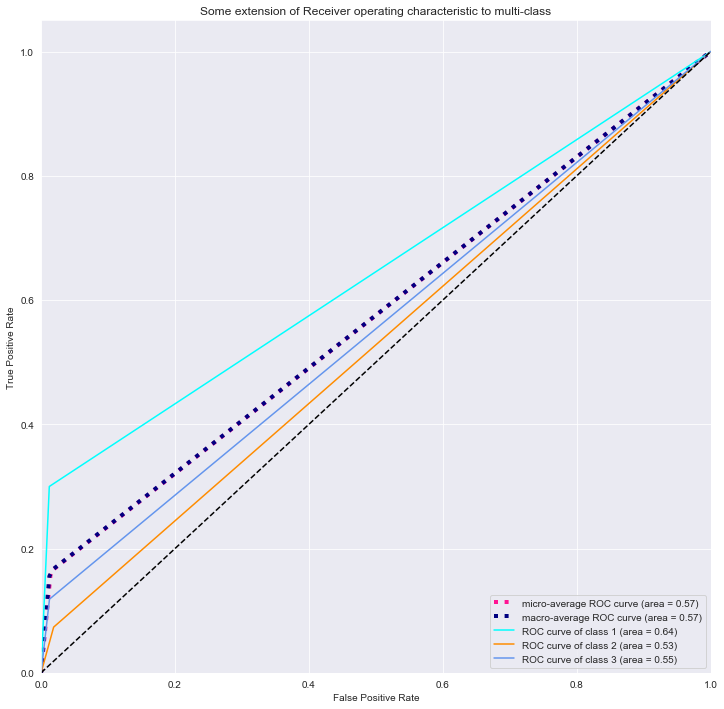

One-vs-Rest ROC AUC scores:
0.813492 (macro),
0.813004 (weighted by prevalence)


(array([[[8279,  103],
         [2869, 1229]],
 
        [[8150,  156],
         [3867,  307]],
 
        [[8168,  104],
         [3709,  499]]]), None, None)

In [53]:
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import MinMaxScaler
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from scipy import interp
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
multiclass_classifier(X,target_train,forest,[2,1,0])

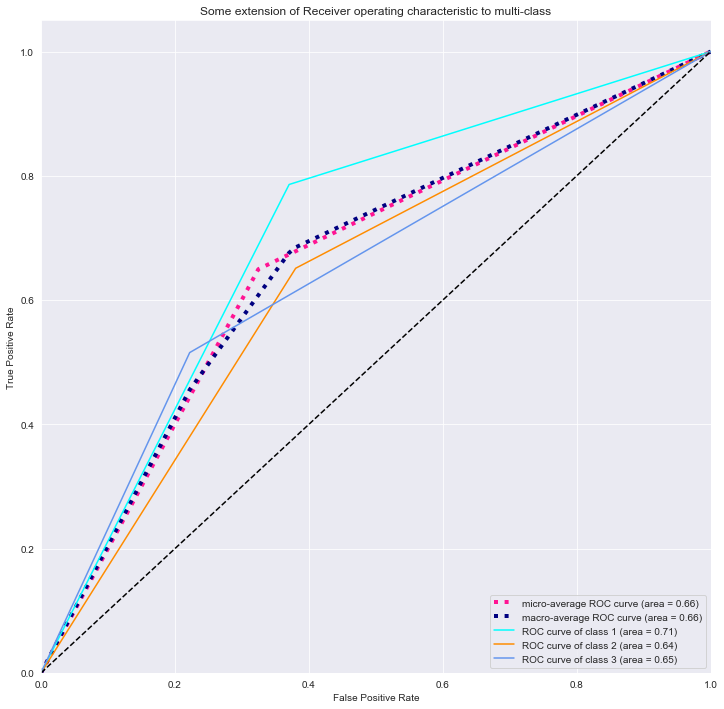

One-vs-Rest ROC AUC scores:
0.702671 (macro),
0.702344 (weighted by prevalence)


(array([[[5277, 3105],
         [ 877, 3221]],
 
        [[5148, 3158],
         [1456, 2718]],
 
        [[6436, 1836],
         [2039, 2169]]]), None, None)

In [54]:
multiclass_classifier(X,target_train,clf,[2,1,0])

/Users/flatironschool/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


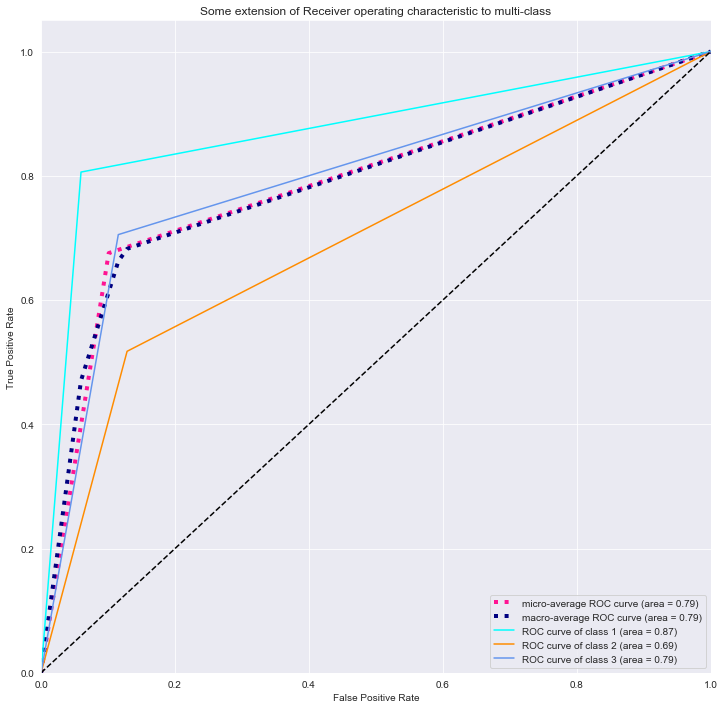

One-vs-Rest ROC AUC scores:
0.885819 (macro),
0.885427 (weighted by prevalence)


(array([[[7882,  500],
         [ 795, 3303]],
 
        [[7239, 1067],
         [2014, 2160]],
 
        [[7318,  954],
         [1240, 2968]]]), None, None)

In [55]:
multiclass_classifier(X,target_train,lr,[2,1,0])

In [20]:
print((cv.vocabulary_))

{'tasty': 26861, 'didnt': 8317, 'quite': 21459, 'have': 12941, 'enough': 9724, 'spinach': 25443, 'so': 24996, 'added': 1810, 'some': 25082, 'mushrooms': 17878, 'they': 27328, 'were': 29744, 'filling': 10642, 'thanks': 27175, 'my': 17927, 'children': 5793, 'wanting': 29477, 'cookies': 6852, 'last': 15433, 'night': 18246, 'but': 4787, 'had': 12726, 'no': 18287, 'eggs': 9441, 'wasnt': 29526, 'sure': 26407, 'if': 13731, 'you': 30563, 'could': 7026, 'even': 9911, 'make': 16386, 'without': 30049, 'decided': 7844, 'to': 27737, 'google': 12104, 'it': 14417, 'found': 11245, 'this': 27421, 'recipe': 22158, 'and': 2465, 'try': 28255, 'since': 24585, 'everything': 9946, 'on': 18839, 'hand': 12810, 'br': 4341, 'tell': 26998, 'that': 27195, 'these': 27304, 'are': 2789, 'delicious': 8018, 'none': 18307, 'of': 18625, 'us': 28915, 'thought': 27498, 'too': 27879, 'sweet': 26508, 'although': 2334, 'used': 28928, 'just': 14866, 'smidge': 24857, 'less': 15656, 'white': 29849, 'sugar': 26248, 'we': 29623, '

In [21]:
word_coeff = zip(cv.get_feature_names(), lr.coef_[0])
word_to_coeff = {word: coeff for word, coeff in word_coeff}

most_accurate_positive_words=[]
for best_positive_words in sorted(
    word_to_coeff.items(), 
    key=lambda x: x[1])[:10]:
    most_accurate_positive_words.append(best_positive_words)

print (f"The 10 words with the highest prediction accuracy for the positive reviews are:\n {most_accurate_positive_words}\n")
    

most_accurate_negative_words=[]    
for best_negative_words in sorted(
    word_to_coeff.items(), 
    key=lambda x: x[1],
    reverse=True)[:10]:
    most_accurate_negative_words.append(best_negative_words)

print (f"The 10 words with the highest prediction accuracy for the negative reviews are:\n {most_accurate_negative_words}\n")

The 10 words with the highest prediction accuracy for the positive reviews are:
 [('delicious', -1.341950472306609), ('loved', -1.2218006908812233), ('thanks', -1.1371391997966405), ('excellent', -1.0314235910067002), ('wonderful', -0.9926858756083021), ('enjoyed', -0.9735507915753692), ('yummy', -0.9598634011321958), ('perfect', -0.8836657644146424), ('tasty', -0.8645225263614205), ('thank', -0.8534723259463146)]

The 10 words with the highest prediction accuracy for the negative reviews are:
 [('waste', 1.0946336227662177), ('terrible', 1.080667398761908), ('awful', 1.0040376003224074), ('horrible', 0.9828313575336379), ('worst', 0.9458237176884363), ('disappointing', 0.9132574166303901), ('sorry', 0.8869152851788181), ('sounded', 0.8306211587807875), ('disappointed', 0.7927037139553246), ('inedible', 0.7804386454052703)]



In [22]:
len(cv.get_feature_names())
X[3,:]

<1x30795 sparse matrix of type '<class 'numpy.int64'>'
	with 9 stored elements in Compressed Sparse Row format>

In [23]:
# sorted(word_to_coeff.items(), key=lambda x: x[1],reverse=True)

# Further Processing
As can be seen above, our accuracy for the model isn't bad! There are still ways we can improve this though. One common technique is to remove stop-words - words such as it/he/she/the/as which distort the frequency of all words in the corpus.However we can also see that that the best words have repetition (thanks, thank). This is where Stemming and Lemmatization come in and reduce these "duplicates" down to one word. There are also other factors that could be influencing our data such as phrasing - E.g. where one person has said "loved this recipe" someone else may have said "didn't love it" - a perfect use case for n-grams - a method which allows us to not only look at single words, but also of phrases consisting of n words.


## Stop-Words
I am not sure whether to remove stop words as they may contribute positively to our model in context with n-grams ("loved this recipe" or "didn't love it")

In [24]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords.word('english')

# print(lr.coef_)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/flatironschool/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


AttributeError: 'WordListCorpusReader' object has no attribute 'word'

## Stemming

In [ ]:
from nltk.stem.porter import PorterStemmer


## Lemmatization

## TF-IDF and n-grams

In [ ]:
all_reviews_train[1]

# Final Model

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(binary=True,ngram_range=(1,2))
tfidf.fit(all_reviews_train)
X = tfidf.transform(all_reviews_train)
X_final_test = tfidf.transform(all_reviews_test)

NameError: name 'all_reviews_train' is not defined

In [187]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

target=[]

for i in range(39000):
    if i<13000:
        target.append(2)
    elif 13001<=i<26000:
        target.append(1)
    else:
        target.append(0)

X_train, X_test, y_train, y_test = train_test_split(X, target, train_size = 0.75,random_state=2019)



Accuracy for C=0.01: 0.7249230769230769
Accuracy for C=0.05: 0.7394871794871795
Accuracy for C=0.25: 0.7569230769230769
Accuracy for C=0.5: 0.765948717948718
Accuracy for C=1: 0.7721025641025641


In [1]:
def LogReg(X, y, lam, alpha, iterations):

    # Number of training examples
    m = len(y)

    # Initialise our values of theta to 0
    theta = np.zeros(len(X))

    # Create a vector for errors in gradient
    grad = np.zeros(len(theta));

    for i in range(0,iterations):
        while i<iterations:
        # Sigmoid function g(z)
            z = (np.dot(X,theta))
            g = (1+np.exp(-z))**-1

        # Hypothesis == g(z)
            h = g

        # Cost function for both situations where y=0 or y=1
            cost_function = (np.dot(-y.transpose(),np.log(h))) - (np.dot((1-y.transpose()),np.log(1-h))) + ((lam/(2*m))*(sum((theta)**2)))

            J = (-1/m)*(cost_function.sum())
            grad = (1 / m) * (np.dot(X.transpose(),(h - y)))+((lam/m)*theta)
            theta = theta - (alpha*grad)
            i+=1
            print(J)
        else:
            break

    return((theta.transpose()[0]), (J), g.transpose()[0])

LogReg(X_train,y_train,0,0.1,1000)

NameError: name 'X_train' is not defined

In [ ]:
for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
    lr = LogisticRegression(C=c)
    lr.fit(X_train, y_train)
    print (f"Accuracy for C={c}: {accuracy_score(y_test, lr.predict(X_test))}")

In [184]:
import warnings
warnings.filterwarnings("ignore")

In [185]:
lr = LogisticRegression(C=1)
lr.fit(X_train, target_train)
print (f"Final Accuracy: {accuracy_score(target, lr.predict(X_test))}")


Final Accuracy: 0.7727692307692308


In [190]:
tfidf.vocabulary_

{'very': 385334,
 'good': 144838,
 'used': 380308,
 'low': 201885,
 'fat': 121817,
 'parmesan': 257104,
 'and': 20556,
 'egg': 110351,
 'substitute': 330077,
 'to': 363292,
 'lower': 202054,
 'the': 345731,
 'total': 370320,
 'even': 114757,
 'further': 139733,
 'this': 357840,
 'is': 175999,
 'definitely': 93458,
 'going': 144547,
 'be': 39528,
 'regular': 286693,
 'side': 307673,
 'dish': 101095,
 'at': 32188,
 'our': 250397,
 'house': 164941,
 'very good': 385664,
 'good used': 145951,
 'used low': 381171,
 'low fat': 201931,
 'fat parmesan': 122026,
 'parmesan and': 257110,
 'and egg': 21843,
 'egg substitute': 110558,
 'substitute to': 330219,
 'to lower': 364762,
 'lower the': 202092,
 'the total': 351357,
 'total fat': 370352,
 'fat even': 121935,
 'even further': 114971,
 'further this': 139776,
 'this is': 358572,
 'is definitely': 176408,
 'definitely going': 93554,
 'going to': 144591,
 'to be': 363581,
 'be regular': 40507,
 'regular side': 286986,
 'side dish': 307715,
 'd

In [203]:
word_coeff = zip(tfidf.get_feature_names(), lr.coef_[0])
word_to_coeff = {word: coeff for word, coeff in word_coeff}

most_accurate_positive_words=[]
for best_positive_words in sorted(
    word_to_coeff.items(), 
    key=lambda x: x[1])[:10]:
    most_accurate_positive_words.append(best_positive_words[0])

most_accurate_negative_words=[]    
for best_negative_words in sorted(
    word_to_coeff.items(), 
    key=lambda x: x[1],
    reverse=True)[:10]:
    most_accurate_negative_words.append(best_negative_words[0])
    
print (f"""The 10 words with the highest prediction accuracy for the positive reviews are:
        {most_accurate_positive_words}\n""")

print (f"""The 10 words with the highest prediction accuracy for the negative reviews are:
        {most_accurate_negative_words}\n""")

The 10 words with the highest prediction accuracy for the positive reviews are:
        ['thanks', 'great', 'delicious', 'loved', 'used', 'wonderful', 'made for', 'easy', 'yummy', 'good']

The 10 words with the highest prediction accuracy for the negative reviews are:
        ['not', 'sorry', 'at all', 'terrible', 'bland', 'no', 'awful', 'waste', 'horrible', 'disappointed']



In [193]:
for best_positive in sorted(
    word_to_coeff.items(), 
    key=lambda x: x[1], 
    reverse=True)[:5]:
    print (best_positive)

for best_negative in sorted(
    word_to_coeff.items(), 
    key=lambda x: x[1])[:5]:
    print (best_negative)

('not', 7.164076497138657)
('sorry', 6.118739724380301)
('at all', 4.854272738114416)
('terrible', 4.231425605082169)
('bland', 4.194815849282722)
('thanks', -8.576975178049606)
('great', -6.491883903992558)
('delicious', -6.172865919178695)
('loved', -5.762901411374422)
('used', -5.602237366245969)
